In [2]:
import os
import pickle

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from experiments.logisticRegression.mnist.load_mnist import mnist_dataset
from experiments.logisticRegression.utils import get_tgt_log_density
from variational.exponential_family import GenericMeanFieldNormalDistribution, NormalDistribution, MeanFieldNormalDistribution

flipped_predictors = mnist_dataset(path_prefix="..")
_, flipped_predictors_test = mnist_dataset(return_test=True, flip=False, path_prefix="..")
predictors_test, labels_test = flipped_predictors_test
N, dim = flipped_predictors.shape

# Gaussian Prior
my_prior_covariance = 25 * jnp.identity(dim)
#my_prior_covariance = my_prior_covariance.at[0, 0].set(400)
my_prior_log_density = NormalDistribution(jnp.zeros(dim), my_prior_covariance).log_density
tgt_log_density = jax.vmap(get_tgt_log_density(flipped_predictors, my_prior_log_density))

PKLs = []
PKL_titles = []
for file in os.listdir("./"):
    if file.endswith(".pkl"):
        PKLs.append(pickle.load(open(file, "rb")))
        PKL_titles.append(str(file))

full_gaussian = GenericMeanFieldNormalDistribution(dimension=dim)

lossesPKLs = []
lossesPKL_titles = []
for file in os.listdir("./losses/"):
    if file.endswith(".pkl"):
        lossesPKLs.append(pickle.load(open("./losses/" + file, "rb")))
        lossesPKL_titles.append(str(file))

In [27]:
mean, cov = full_gaussian.get_mean_cov(PKLs[0]['res'][-1][:-1])
OP_key = jax.random.PRNGKey(0)
samples = jax.random.multivariate_normal(key=OP_key, mean=mean, cov=jnp.diag(cov), shape=(1000,))
plt.hist(tgt_log_density(samples), bins=50)

In [21]:
plt.plot(full_gaussian.get_mean_cov(PKLs[1]['res'][-100][:-1])[1])

In [2]:
def logistic_fun(x):
    return 1/(jnp.exp(-x)+1)
mean_cov_tuple = full_gaussian.get_mean_cov(PKLs[0]['res'][-100][:-1])
learnt_gaussian = MeanFieldNormalDistribution(*mean_cov_tuple)
OP_key = jax.random.PRNGKey(0)
def eval_model(OP_key, gaussian):
    sample_keys = jax.random.split(OP_key, 10)
    sampled_betas = gaussian.sampling_method(sample_keys)
    X = predictors_test@sampled_betas.T
    idxs = jnp.where(logistic_fun(X)[:,0]<=0.5)
    predictions = jnp.zeros(shape=(10, 1954))
    rates = jnp.zeros(shape=(10,))
    for i in range(10):
        _ = jnp.zeros(shape=(1954)) - 1
        #print(jnp.where(logistic_fun(X)[:,i]<=0.5))
        _ = _.at[logistic_fun(X)[:,i]>0.5].set(1)
        predictions = predictions.at[i].set(_)
        rate = (jnp.sum(labels_test == _)/1954)
        print(rate)
        rates = rates.at[i].set(rate)
    print(jnp.mean(rates), jnp.std(rates))
    return rates
eval_model(OP_key, learnt_gaussian)

0.9912999
0.9861822
0.986694
0.9907881
0.9882293
0.9943705
0.9907881
0.9907881
0.9928352
0.98311156
0.9895086 0.0032306449


Array([0.9912999 , 0.9861822 , 0.986694  , 0.9907881 , 0.9882293 ,
       0.9943705 , 0.9907881 , 0.9907881 , 0.9928352 , 0.98311156],      dtype=float32)

In [ ]:
mean_cov_tuple = PKLs[1]['states'][0][-1], jnp.exp(PKLs[1]['states'][1][-1])
learnt_gaussian = MeanFieldNormalDistribution(*mean_cov_tuple)
eval_model(OP_key, learnt_gaussian)

In [3]:
PKL_titles

['inf1em.pkl', 'ngd.pkl', '10_1.pkl', 'blackjax.pkl', '1_1em3.pkl']

In [21]:

d = {1: 'inf_1em', 2: '10_1', 0: '1_1em3'}

concatened_PKLs = [
    
    jnp.concat([PKLs[idx]['res'] for idx, title in enumerate(PKL_titles) if d[i] in title])
for i in range(3) 
]

for i, to_pickle in enumerate(concatened_PKLs):
    file = open(f"{i}_{d[i]}.pkl", "wb")
    pickle.dump({'res':to_pickle},file)


In [33]:
for idx in range(3):
    with open(f'{idx}.pickle', 'wb') as handle:
        pickle.dump({'res':concatened_PKLs[idx]}, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [61]:
edit_pkl = jnp.concat([PKLs[-1]['res'], PKLs[-1]['res'][..., -1][..., jnp.newaxis]+1], axis=-1)


with open(f'blackjax.pickle', 'wb') as handle:
    pickle.dump({'res':edit_pkl}, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [74]:

with open(f'bj.pkl', 'wb') as handle:
    pickle.dump({'res':edit_pkl}, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [2]:
concatened_PKLs = []
states0 = []
states1 = []
for idx, title in enumerate(PKL_titles):
    if "blackjax" in title:
        states0.append(PKLs[idx]['states'][0]) 
        states1.append(PKLs[idx]['states'][1])
states0 = jnp.concat(states0)
states1 = jnp.concat(states1)
with open(f'bj.pkl', 'wb') as handle:
    pickle.dump({'states':[states0, states1]}, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
concatened_PKLs = []
states0 = []
states1 = []
for idx, title in enumerate(PKL_titles):
    if "blackjax" in title:
        states0.append(PKLs[idx]['states'][0]) 
        states1.append(PKLs[idx]['states'][1])
states0 = jnp.concat(states0)
states1 = jnp.concat(states1)
with open(f'bj.pkl', 'wb') as handle:
    pickle.dump({'states':[states0, states1]}, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
res_ngd = []
for idx, title in enumerate(PKL_titles):
    if 'gaussian_meanfield_ngd' in title:
        res_ngd.append(PKLs[idx]['res'][:,:101,:])
res_ngd = jnp.concat(res_ngd)
with open(f'ngd.pkl', 'wb') as handle:
    pickle.dump({'res':res_ngd}, handle, protocol=pickle.HIGHEST_PROTOCOL)

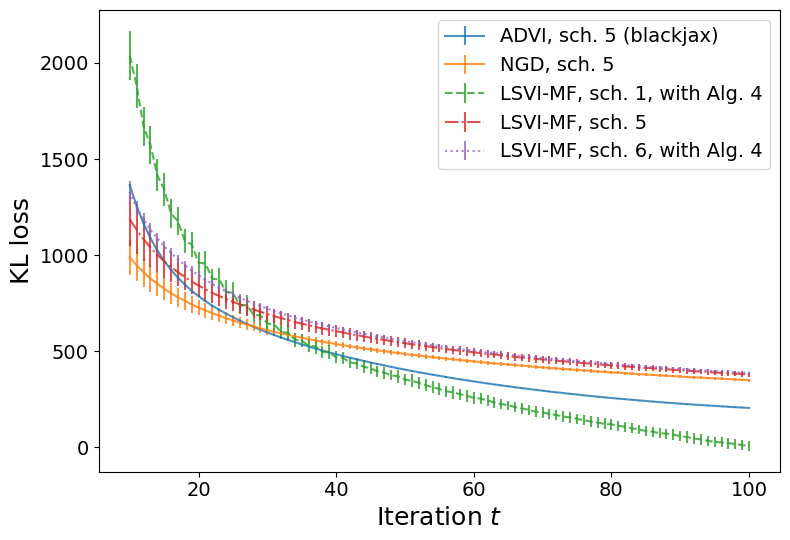

In [7]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

start = 10
end = 101
legends = [
    "NGD, sch. 5",
    "LSVI-MF, sch. 5",
    "LSVI-MF, sch. 1, with Alg. 4",
    "ADVI, sch. 5 (blackjax)",
    "LSVI-MF, sch. 6, with Alg. 4"
]

# Wider figure for LaTeX side-by-side placement
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))

# colors = ["black", "green", "blue", "purple", "red"]
line_styles = ["-", "-", "--", "-.", ":"]

# Plot selected curves with clean, distinguishable styles
for idx, ls in zip([3, 0, 2, 1, 4], line_styles):
    ax.errorbar(
        x=jnp.arange(start, end),
        y=lossesPKLs[idx].mean(axis=0)[start:end],
        yerr=lossesPKLs[idx].std(axis=0)[start:end],
        label=legends[idx],
        elinewidth=1.5,
        linewidth=1.5,
        linestyle=ls,
        alpha=0.8
    )

# Axis labels
ax.set_xlabel(r"Iteration $t$", fontsize=18)
ax.set_ylabel("KL loss", fontsize=18)

# Ticks and layout
ax.tick_params(labelsize=14)
ax.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.savefig("MNIST_loss.pdf", dpi=300)
